# Neural Message Passing for Quantum Chemistry

Ref: https://arxiv.org/pdf/1704.01212.pdf

Assumptions:
1. Hidden states for atoms are not updated (only for atoms).

## 1. Directed models

In [161]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [199]:
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.autograd import Variable
from utils import rolling_mean
from data import DataPreprocessor
from mpnn.mpnn_directed import MPNNdirected
from mpnn.directed import Rd, Vd, Ud, Ed

In [163]:
at_feat = 75
edg_feat = 6
passes = 4
rd = Rd(inp_size=at_feat*2, hid_size=32)
vd = Vd(inp_size=at_feat)
ud = Ud(inp_size=at_feat*2+edg_feat, out_size=at_feat)
ed = Ed(inp_size=edg_feat)

In [200]:
mpnn = MPNNdirected(rd, ud, vd, ed, passes)

In [110]:
DATASET = 'data.test'

In [111]:
data = DataPreprocessor(DATASET, filter_dots=True, filter_atoms=True)

In [112]:
data.load_dataset()

File data.test read. In total 1696 lines.


In [113]:
data.filter_data()

Data filtered, in total 220 smiles deleted


In [114]:
train_smiles, train_labels, valid_smiles, valid_labels, test_smiles, test_labels = data.get_data()

File data.test read. In total 1696 lines.
Data filtered, in total 220 smiles deleted
About to generate scaffolds
Generating scaffold 0/1476
Generating scaffold 1000/1476
About to sort in scaffold sets


In [115]:
losses = []

In [ ]:
for j in range(100):
    for i in range(100):
        loss = mpnn.make_opt_step(train_smiles[i:i+1], train_labels[i:i+1], passes)
        print(i, loss)
        losses.append(loss)
    print(j)


0 0.2518308758735657
1 0.24897924065589905
2 0.24613520503044128
3 0.23758557438850403
4 0.2286469042301178
5 0.24088028073310852
6 0.22219446301460266
7 0.23012609779834747
8 0.17206139862537384
9 0.21502570807933807
10 0.3623237609863281
11 0.1955443024635315
12 0.20598377287387848
13 0.21287111937999725
14 0.20524942874908447
15 0.4006253480911255
16 0.31148678064346313
17 0.17003174126148224
18 8.774836896918714e-05
19 0.1909409761428833
20 0.1708410680294037
21 0.19698423147201538
22 0.32186374068260193
23 0.19631384313106537
24 0.18147459626197815
25 0.26726436614990234
26 0.26783591508865356
27 0.1476643979549408
28 0.08650998026132584
29 0.14515051245689392
30 0.16927094757556915
31 0.17562970519065857
32 0.2083476483821869
33 0.17105230689048767
34 0.09335259348154068
35 0.030412064865231514
36 0.08645587414503098
37 0.07453926652669907
38 0.03697970509529114
39 0.9941427707672119
40 1.849216069160775e-08
41 4.066528163093608e-06
42 2.4962119038463015e-09
43 4.32794511340262e-

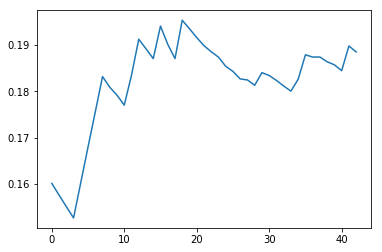

In [98]:
plt.plot(rolling_mean(losses, 100))

In [18]:
res = []
for i in range(100):
    res.append(forward_pass(mpnn, train_smiles[i], passes).data[0][0])

(array([ 72.,  22.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([  5.11260358e-25,   9.96290445e-02,   1.99258089e-01,
          2.98887134e-01,   3.98516178e-01,   4.98145223e-01,
          5.97774267e-01,   6.97403312e-01,   7.97032356e-01,
          8.96661401e-01,   9.96290445e-01]),
 <a list of 10 Patch objects>)

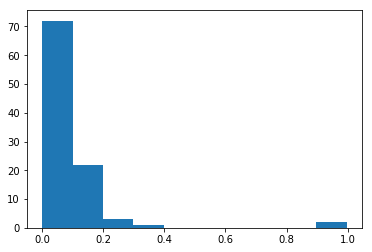

In [19]:
plt.hist(res)

In [17]:
def forward_pass(self, x, t):
    g, h = self.get_features_from_smiles(x)
    g2, h2 = self.get_features_from_smiles(x)
#     for k, v in h.items():
#         print(v.data.numpy())
    for k in range(0, t):
        self.single_message_pass(g, h, k)
#         print('*'*33)
#         print(h[0])
    y_pred = self.R(h, h2)
    return y_pred

In [76]:
g, h = mpnn.get_features_from_smiles(train_smiles[10])

In [ ]:
np.array(losses[-50:]).mean()

In [ ]:
np.array(train_labels[:100]).mean()

In [ ]:
for i in range(50):
    print(i, int(train_labels[i]), int(res[i]))

In [ ]:
r = (np.array(res) > 0.5).astype(int)

In [198]:
torch.randn((2, 3)).split(1, dim=0)

(
 -1.4193 -1.2841 -0.8369
 [torch.FloatTensor of size 1x3], 
  0.1023  0.8117  0.1031
 [torch.FloatTensor of size 1x3])

## 2. Undirected models

In [ ]:
for p in mpnn.params:
    print(p.requires_grad)

In [ ]:
mpnn.params[-2]

In [ ]:
for p in mpnn.params:
    print(p.data.size())